In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
from itertools import chain

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
import pickle
from sklearn.model_selection import train_test_split

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Let's use NKJP data to NER system

To download NKJP go here
http://clip.ipipan.waw.pl/NationalCorpusOfPolish
and get manually annotated subcorpus archive
Script nkjp_download.py helps to transform all XML data to Python list of lists with documents, where word has its POS tag and Named entity as target variable

## Features

Next, define some features. In this example we use word identity, word suffix, word shape and word POS tag; also, some information from nearby words is used. 

sklearn-crfsuite (and python-crfsuite) supports several feature formats; here we use feature dicts.

This is what word2features extracts:

Extract features from the data:

In [3]:
with open("word_data_file.obj", "rb") as infile:
    data = pickle.load(infile)

def word2features(doc, i):
    word = doc[i][0]
    postag = doc[i][1]
    
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag 
    }
    if i > 0:
        word1 = doc[i-1][0]
        postag1 = doc[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1
        })
    else:
        features['BOS'] = True
        
    if i < len(doc)-1:
        word1 = doc[i+1][0]
        postag1 = doc[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1
        })
    else:
        features['EOS'] = True
                
    return features

# A function for extracting features in documents
def extract_features(doc):
    return [word2features(doc, i) for i in range(len(doc))]

# A function fo generating the list of labels for each document
def get_labels(doc):
    return [label for (token, postag, label) in doc]

In [4]:
%%time
X = [extract_features(doc) for doc in data]
y = [get_labels(doc) for doc in data]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

CPU times: user 3.59 s, sys: 308 ms, total: 3.9 s
Wall time: 3.95 s


## Training

To see all possible CRF parameters check its docstring. Here we are useing L-BFGS training algorithm (it is default) with Elastic Net (L1 + L2) regularization.

In [6]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    c1=0.1, 
    c2=0.01, 
    max_iterations=200, 
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CPU times: user 2min 56s, sys: 1.95 s, total: 2min 58s
Wall time: 3min 3s


## Evaluation

There is much more O entities in data set, but we're more interested in other entities. To account for this we'll use averaged F1 score computed for all labels except for O. ``sklearn-crfsuite.metrics`` package provides some useful metrics for sequence classification task, including this one.

In [7]:
labels = list(crf.classes_)
labels.remove('I')
labels

['orgName', 'persName', 'date', 'geogName', 'placeName', 'time']

In [29]:
%%time
y_pred = crf.predict(X_test)
print(metrics.flat_f1_score(y_test, y_pred, 
                      average='weighted', labels=labels))

0.690213215724
CPU times: user 3.13 s, sys: 59 ms, total: 3.19 s
Wall time: 3.2 s


Inspect per-class results in more detail:

In [30]:
print(metrics.flat_classification_report(
    y_test, y_pred, labels=labels, digits=3
))

             precision    recall  f1-score   support

    orgName      0.655     0.530     0.586      9173
  placeName      0.782     0.697     0.737      4278
   persName      0.843     0.832     0.838      7594
   geogName      0.625     0.304     0.409      2508
       date      0.894     0.822     0.856      2171
       time      0.661     0.519     0.581       214

avg / total      0.748     0.649     0.690     25938



## Hyperparameter Optimization

To improve quality try to select regularization parameters using randomized search and 3-fold cross-validation.

I takes quite a lot of CPU time and RAM (we're fitting a model ``50 * 3 = 150`` times), so grab a tea and be patient, or reduce n_iter in RandomizedSearchCV, or fit model only on a subset of training data.

In [8]:
%%time
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    max_iterations=100, 
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score, 
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space, 
                        cv=3, 
                        verbose=1, 
                        n_jobs=-1, 
                        n_iter=20, 
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 32.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 45.2min finished


CPU times: user 5min 6s, sys: 1min 49s, total: 6min 56s
Wall time: 47min 16s


Best result:

In [9]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.29852068362164663, 'c2': 0.056854050339045628}
best CV score: 0.6694857204352365
model size: 5.15M


### Check parameter space

A chart which shows which ``c1`` and ``c2`` values have RandomizedSearchCV checked. Red color means better results, blue means worse.

Dark blue => 0.6581, dark red => 0.6695


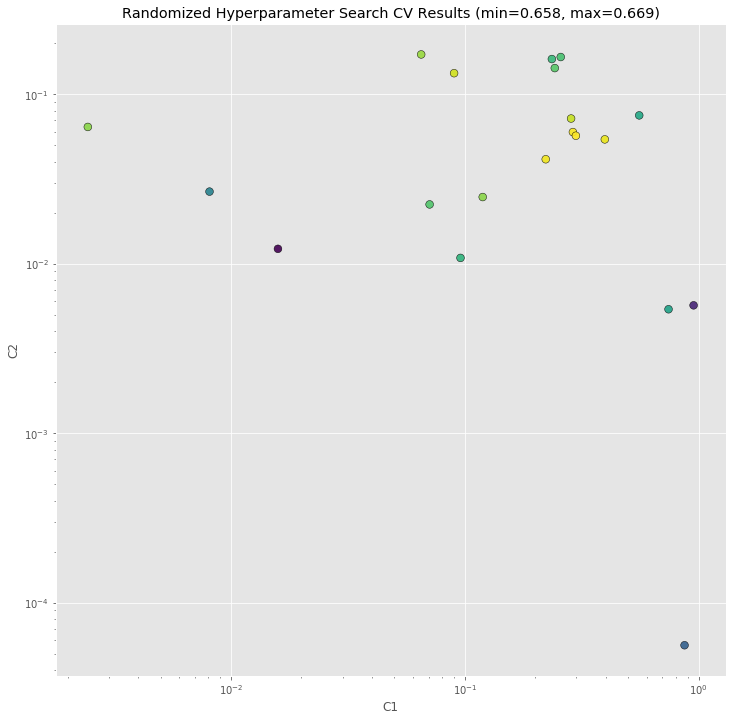

In [10]:
_x = [s.parameters['c1'] for s in rs.grid_scores_]
_y = [s.parameters['c2'] for s in rs.grid_scores_]
_c = [s.mean_validation_score for s in rs.grid_scores_]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

## Check best estimator on our test data

As you can see, quality is improved.

In [12]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=labels, digits=3
))

             precision    recall  f1-score   support

    orgName      0.672     0.483     0.562      8070
   persName      0.818     0.819     0.819      6945
       date      0.909     0.787     0.844      2135
   geogName      0.715     0.418     0.527      1873
  placeName      0.800     0.685     0.738      4368
       time      0.853     0.254     0.392       389

avg / total      0.766     0.637     0.689     23780



## Let's check what classifier learned

In [13]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
I      -> I       2.470137
orgName -> orgName 1.892967
time   -> time    1.747993
date   -> date    1.089337
geogName -> geogName 0.994069
I      -> orgName 0.970243
placeName -> placeName 0.926725
persName -> persName 0.896981
orgName -> I       0.808718
I      -> placeName 0.775374
I      -> persName 0.512051
I      -> time    0.296102
I      -> geogName 0.241140
placeName -> I       0.202964
persName -> I       0.180517
I      -> date    0.052852
geogName -> I       0.034679
date   -> I       -0.197095
time   -> I       -0.222474
orgName -> time    -0.229339

Top unlikely transitions:
geogName -> date    -1.200197
time   -> placeName -1.225423
time   -> date    -1.231922
orgName -> persName -1.236858
date   -> placeName -1.270045
time   -> geogName -1.438669
time   -> orgName -1.450333
geogName -> placeName -1.475310
geogName -> time    -1.487044
placeName -> persName -1.531154
persName -> placeName -1.542137
date   -> time    -1.612142
date   -> persName -1.

We can see that, for example, it is very likely that the beginning of an organization name (B-ORG) will be followed by a token inside organization name (I-ORG), but transitions to I-ORG from tokens with other labels are penalized.

Check the state features:

In [14]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))    

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
11.899493 I        word.lower():wszyscy
9.122277 date     word.lower():lutego
8.909055 date     word.lower():stycznia
8.896559 date     word.lower():kwietnia
8.726292 date     word.lower():sierpnia
8.650108 I        word.lower():oklaski
8.567726 date     word.lower():września
8.368863 date     word.lower():listopadzie
8.354929 date     word.lower():kwietniu
8.253207 date     word.lower():grudniu
8.152704 persName word.lower():boże
8.012640 date     word.lower():czerwca
7.976721 date     word.lower():styczniu
7.948044 placeName word.lower():rosyjskiego
7.655188 date     word.lower():lipca
7.583156 date     word.lower():listopada
7.542869 I        word.lower():czego
7.541966 placeName word.lower():niemieckiego
7.537600 placeName word.lower():polskiego
7.504737 date     word.lower():październiku
7.396052 date     word.lower():marca
7.293177 placeName word.lower():francuskiego
7.140867 persName word.lower():"babci"
7.081414 date     word.lower():lutym
7.061899 I        word.l